# NLP Project: classification of WhatsApp messages



For this project, you will be analyzing text message data using Natural Language Processing techniques and libraries.

You are free to use the dataset that is provided or collect your own SMS data from a service like WhatsApp or just from your device’s messaging default app.

You will be diving deeper into NLP skills in order to gain a better understanding of the insights chat data can offer.

Dataset

You have two options:

Option 1: While there are many ways to procure text message data, here we have chosen the The National University of Singapore SMS Corpus dataset, made publicly available by The National University of Singapore. This dataset contains 67,093 text messages (SMSs) taken from the corpus on Mar 9, 2015 and is mostly comprised of messages from Singaporeans and students attending the University.

This corpus was collected by Tao Chen and Min-Yen Kan:

Tao Chen and Min-Yen Kan (2013). Creating a Live, Public Short Message Service Corpus: The NUS SMS Corpus. Language Resources and Evaluation, 47(2)(2013), pages 299-355. URL: https://link.springer.com/article/10.1007%2Fs10579-012-9197-9

Data Description


**id**	  Unique identifier for each message.

**Message**    The message contents.

**length**	    Total number of characters in the message.

**country**	    Country the sender is from.


**Date**	  Month and Year a message was sent.


Data provided by Codecademy.

**The aim of this project is to classify the messages based on sentiment (positive or negative emotion), as well as compare statistically sentiment between the countries.**

## Loading Packages and Data




In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
import spacy
from nltk import Tree


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

Import the file as pandas dataframe.

In [83]:
text = pd.read_csv('clean_nus_sms.csv')

## **Exploring The Dataset**

In [84]:
text.head(5)

,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


Checking the size of the dataframe and data types.

In [85]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


There are 3 fewer data points for the message column than the rest.
All columns contain text data except id column, 50K data points.

In [86]:
text.describe()

,Unnamed: 0,id
count,48598.000000,48598.000000
mean,27138.722355,21106.315342
std,16206.056352,12189.313543
min,0.000000,1.000000
25%,12852.250000,12100.000000
50%,26916.500000,18553.000000
75%,40080.500000,29964.500000
max,55834.000000,45718.000000


Shows that Message has 3 missing rows.

In [87]:
text.isna().sum()

,0
Unnamed: 0,0
id,0
Message,3
length,0
country,0
Date,0


## **Preprocessing Data**

To classify messages based on sentiment, I will do the following:

*   text preprocessing with regex and NLTK
*   exploratory data analysis with seaborn and pandas
*   sentiment analysis using bag-of-words and Naive Bayes Classifier models



First, the text needs to be cleaned up, there is a lot of noise in the messages data points which provide no information and jumble up words.


Had to remove:


*   3 empty messages
*   punctuation
*   stopwords
*   URLs
*   HTMLs


Normalise text using lower casing.




Remove 3 empty messages with dropna()

In [88]:
text = text.dropna()

In [89]:
len(text)

48595

In [90]:
text.shape

(48595, 6)

Use str() and lower() methods to make all the text lower case, to every string in each column.

In [91]:
text['Message_lowercase'] = text['Message'].str.lower()

In [13]:
text.head(3)

,Unnamed: 0,id,Message,length,country,Date,Message_lowercase
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...


Remove any punctuation using str() and replace() methods with '[^\w\s]' to label all punctuation, '' to replace it with nothing.

In [92]:
text['Message_lowercase'] = text['Message_lowercase'].str.replace('[^\w\s]','')

In [15]:
from nltk.corpus import stopwords

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Remove stopwords is one of the most common NLP preprocessing strategies, first checking english stopwords if any information might be lost contextually after their removal.

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

Since removing some of these words might cause loss of information, they will be kept.

Remove HTMLs, use regular expression and a function to remove HTML pattern using , apply to the message column with lambda.

Identify all instances of URL with '<.*?>' and replace with ''.

In [93]:
def remove_html(text):
  html_pattern = re.compile('<.*?>')
  return html_pattern.sub(r'', text)

In [94]:
text['message_clean'] = text['Message_lowercase'].apply(lambda x: remove_html(x))

In [21]:
text.head(5)

,Unnamed: 0,id,Message,length,country,Date,Message_lowercase,message_clean
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...,bugis oso near wat...
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ...","go until jurong point, crazy.. available only ..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...,i dunno until when... lets go learn pilates...
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......,den only weekdays got special price... haiz......
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...,meet after lunch la...


Remove URLs, use regular expression and a function to remove URL pattern using , apply to the message column with lambda.

Identify all instances of URL with 'https?://\S+|www\.\S+' and replace with ''.

In [95]:
def remove_url(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

In [96]:
text['message_clean'] = text['message_clean'].apply(lambda x: remove_url(x))

In [24]:
text.head(5)

,Unnamed: 0,id,Message,length,country,Date,Message_lowercase,message_clean
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...,bugis oso near wat...
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ...","go until jurong point, crazy.. available only ..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...,i dunno until when... lets go learn pilates...
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......,den only weekdays got special price... haiz......
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...,meet after lunch la...


In [25]:
text['message_clean'].head(20)

,message_clean
0,bugis oso near wat...
1,"go until jurong point, crazy.. available only ..."
2,i dunno until when... lets go learn pilates...
3,den only weekdays got special price... haiz......
4,meet after lunch la...
5,m walking in citylink now ü faster come down.....
6,5 nights...we nt staying at port step liao...t...
7,hey pple...$700 or $900 for 5 nights...excelle...
8,yun ah.the ubi one say if ü wan call by tomorr...
9,hey tmr maybe can meet you at yck


## **Exploratory Data Analysis**

Explore data using visualisations to get better understanding of data and the patterns.

Count number of all countries and see how many messages  were sent per country  with nunique() and value_counts().

In [97]:
text['country'].nunique()

40

In [98]:
text['country'].value_counts()

,count
country,
Singapore,22013
SG,9804
India,6901
United States,3749
USA,1931
Sri Lanka,1017
Malaysia,766
Pakistan,751
unknown,602


Some of the countries are represented with acronyms and others with full names, which can cause problems further down the line.

 Use the replace() method to correct the names of each country.

In [99]:
text = text.replace({'country':{'SG':'Singapore',
                            'USA':'United States',
                            'india':'India',
                            'INDIA':'India',
                            'srilanka':'Sri Lanka',
                            'UK':'United Kingdom',
                            'BARBADOS':'Barbados',
                            'jamaica':'Jamaica',
                            'MY':'Malaysia',
                            'unknown':'Unknown'}})

Visualise top 5 countries with the highest number of messages sent using bar plot.

In [29]:
top5_countries = text['country'].value_counts().head(5)

<Axes: xlabel='count', ylabel='country'>

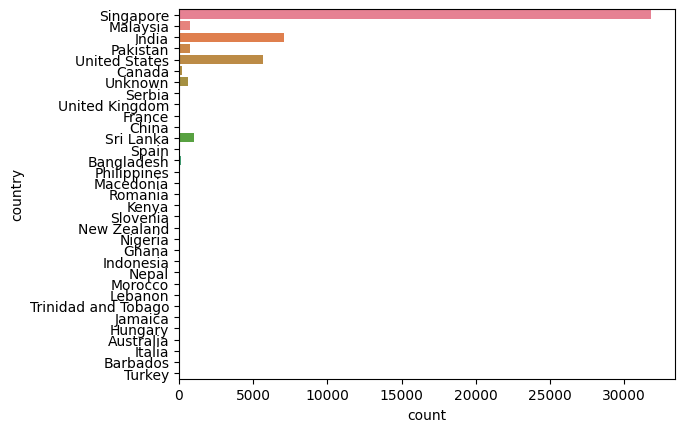

In [30]:
sns.countplot(data=text, y='country', hue='country')

<Axes: xlabel='country'>

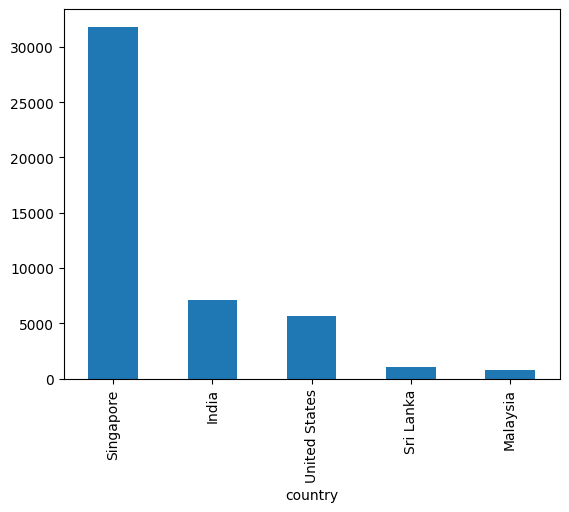

In [31]:
top5_countries.plot.bar()

The countries with the highest number of messages are Singapore, India and United States.

## **Sentiment Analysis**

Already decided to categorise the messsages into 2 classes; negative and positive.

First test the Naive Bayes Classifier to classify sentiment of the Messages column.

Download twitter data and the model, import twitter_samples from nltk corpus.

In [32]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [33]:
from nltk.corpus import twitter_samples

1. Instantiate the tweets that already have positive and negative labels to create training set for the classifier.

In [34]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

Check the distributions of each type of tweets using indexing and len().

In [35]:
print(format(len(positive_tweets)))
print(format(len(negative_tweets)))

5000
5000


View first 5 tweets from each.

In [36]:
print(negative_tweets[0:5])

['hopeless for tmr :(', "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(", '@Hegelbon That heart sliding into the waste basket. :(', '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too', 'Dang starting next week I have "work" :(']


In [37]:
print(positive_tweets[0:5])

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)', '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!', '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!', '@97sides CONGRATS :)', 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']


Evenly distributed, can tokenize.

In [38]:
from nltk.tokenize import word_tokenize

In [39]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
positive_tweets.__class__.__name__

'list'

Tried tokenizing messages here using the nltk module but encountered an error.

In [100]:
tokenized_positive = twitter_samples.word_tokenized(positive_tweets)

AttributeError: 'TwitterCorpusReader' object has no attribute 'word_tokenized'

In [42]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [43]:
positive_tokenized = twitter_samples.tokenize(positive_tweets)

AttributeError: 'TwitterCorpusReader' object has no attribute 'tokenize'

word_tokenize didn't work, so use tokenized() instead.

In [101]:
positive_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tokens = twitter_samples.tokenized('negative_tweets.json')

In [45]:
positive_tokens[0:5]

[['#FollowFriday',
  '@France_Inte',
  '@PKuchly57',
  '@Milipol_Paris',
  'for',
  'being',
  'top',
  'engaged',
  'members',
  'in',
  'my',
  'community',
  'this',
  'week',
  ':)'],
 ['@Lamb2ja',
  'Hey',
  'James',
  '!',
  'How',
  'odd',
  ':/',
  'Please',
  'call',
  'our',
  'Contact',
  'Centre',
  'on',
  '02392441234',
  'and',
  'we',
  'will',
  'be',
  'able',
  'to',
  'assist',
  'you',
  ':)',
  'Many',
  'thanks',
  '!'],
 ['@DespiteOfficial',
  'we',
  'had',
  'a',
  'listen',
  'last',
  'night',
  ':)',
  'As',
  'You',
  'Bleed',
  'is',
  'an',
  'amazing',
  'track',
  '.',
  'When',
  'are',
  'you',
  'in',
  'Scotland',
  '?',
  '!'],
 ['@97sides', 'CONGRATS', ':)'],
 ['yeaaaah',
  'yippppy',
  '!',
  '!',
  '!',
  'my',
  'accnt',
  'verified',
  'rqst',
  'has',
  'succeed',
  'got',
  'a',
  'blue',
  'tick',
  'mark',
  'on',
  'my',
  'fb',
  'profile',
  ':)',
  'in',
  '15',
  'days']]

In [46]:
negative_tokens[0:5]

[['hopeless', 'for', 'tmr', ':('],
 ['Everything',
  'in',
  'the',
  'kids',
  'section',
  'of',
  'IKEA',
  'is',
  'so',
  'cute',
  '.',
  'Shame',
  "I'm",
  'nearly',
  '19',
  'in',
  '2',
  'months',
  ':('],
 ['@Hegelbon',
  'That',
  'heart',
  'sliding',
  'into',
  'the',
  'waste',
  'basket',
  '.',
  ':('],
 ['“',
  '@ketchBurning',
  ':',
  'I',
  'hate',
  'Japanese',
  'call',
  'him',
  '"',
  'bani',
  '"',
  ':(',
  ':(',
  '”',
  'Me',
  'too'],
 ['Dang', 'starting', 'next', 'week', 'I', 'have', '"', 'work', '"', ':(']]

Remove URLs and HTMLs from training tweets so that they will be standardised just as SMS data was.
Save into lists.

In [47]:
positive_cleaned = []
negative_cleaned = []

for tweet in positive_tokens:
  cleaned_tweet = []
  for token in tweet:
    url_cleaned = remove_url(token)
    html_cleaned = remove_html(url_cleaned)
    cleaned_tweet.append(html_cleaned)
  positive_cleaned.append(cleaned_tweet)

for tweet in negative_tokens:
  cleaned_tweet = []
  for token in tweet:
    url_cleaned = remove_url(token)
    html_cleaned = remove_html(url_cleaned)
    cleaned_tweet.append(html_cleaned)
  negative_cleaned.append(html_cleaned)

In [48]:
print(positive_cleaned[:5])

[['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)'], ['@Lamb2ja', 'Hey', 'James', '!', 'How', 'odd', ':/', 'Please', 'call', 'our', 'Contact', 'Centre', 'on', '02392441234', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', ':)', 'Many', 'thanks', '!'], ['@DespiteOfficial', 'we', 'had', 'a', 'listen', 'last', 'night', ':)', 'As', 'You', 'Bleed', 'is', 'an', 'amazing', 'track', '.', 'When', 'are', 'you', 'in', 'Scotland', '?', '!'], ['@97sides', 'CONGRATS', ':)'], ['yeaaaah', 'yippppy', '!', '!', '!', 'my', 'accnt', 'verified', 'rqst', 'has', 'succeed', 'got', 'a', 'blue', 'tick', 'mark', 'on', 'my', 'fb', 'profile', ':)', 'in', '15', 'days']]


In [49]:
print(negative_cleaned[:5])

[':(', ':(', ':(', 'too', ':(']


2. Select features for the classifier.

Sleecr most common words in my corpus, assume they will be the best indicator of both labels, use frequency distribution to select them.

In [50]:
all_tweets = positive_cleaned + negative_cleaned

In [51]:
#changing 2 lists of tokens into 1
all_tweets_tokenized = [token for sublist in all_tweets for token in sublist]

In [52]:
len(all_tweets_tokenized)

78098

Change tweet list to a flat token list.

In [53]:
all_tokens = nltk.FreqDist(token for token in all_tweets_tokenized)

Check number of words.

In [54]:
print(len(all_tokens))

14235


Create frequency distribution of all words.

Choose the most common 10K words.

In [55]:
sentiment_features = [word for (word, freq) in all_tokens.most_common(10000)]

Create feature extractor that identifies which feature is present in a message.

In [56]:
def document_features(document, sentiment_features):
    #make a set list of all the tokens in a message
    document_tokens = set(document)
    features = {}
    #for all my features, check if that feature is in my target message
    for token in sentiment_features:
        #make a dictionary for each message
        features[token] = (token in document_tokens)
    return features

Now create training and test sets, label them according, split into 70% training and 30% test.

Use random library to randomise each tweet.

In [57]:
import random

create positive and negative datasets from my list of tokenised tweets.

In [58]:
positive_tw = [(tweet, "Positive") for tweet in positive_cleaned]
negative_tw = [(tweet, "Negative") for tweet in negative_cleaned]

Create combined dataset.

In [59]:
labelled_tweets = positive_tw + negative_tw

Initiate random number that will allow you to get the same result every time.

Shuffle the order of tweets.

In [60]:
random.seed(101)
random.shuffle(labelled_tweets)

Create list of (token, sentiment) pairs for all features in the tweets list

In [102]:
feature_set = [(document_features(d, sentiment_features),c) for (d,c) in labelled_tweets]
# Separate the dataset into the training and testing sets
train_set, test_set = feature_set[:3000], feature_set[3000:]

## **Naive Bayes Classifier**

Use the NaiveBayesClassifier model with training and test sets to build my sentiment model.

Use classify() function to check the performance of my model on training set.

instant classifier and train it on training set/

In [62]:
from nltk.classify import NaiveBayesClassifier

In [63]:
classifier = NaiveBayesClassifier.train(train_set)

In [64]:
from nltk import classify

Evaluate the model with classify()

In [65]:
print(classify.accuracy(classifier, test_set))

0.9858571428571429


Show 20 most informative features for prediction of the 2 classes.

In [66]:
print(classifier.show_most_informative_features(20))

Most Informative Features
                       ( = True           Negati : Positi =     39.9 : 1.0
                       ) = True           Positi : Negati =     31.2 : 1.0
                       l = True           Negati : Positi =     28.9 : 1.0
                       m = True           Negati : Positi =     26.9 : 1.0
                       r = True           Negati : Positi =     18.2 : 1.0
                       I = True           Positi : Negati =     18.0 : 1.0
                       o = True           Negati : Positi =     17.4 : 1.0
                       ! = True           Positi : Negati =     17.2 : 1.0
                       t = True           Negati : Positi =     16.5 : 1.0
                       1 = True           Positi : Negati =     16.0 : 1.0
                       g = True           Negati : Positi =     15.3 : 1.0
                       : = True           Negati : Positi =     14.7 : 1.0
                       k = True           Negati : Positi =     13.3 : 1.0

Now use my model to classify sentiment of messages.

First try it out one last time on a sample message from the whatsapp corpus before all of it.

In [103]:
sample_message = str(text['message_clean'][50])
print(sample_message)

yup... ok i go home look at the timings then i msg ü again... xuhui going to learn on 2nd may too but her lesson is at 8am


Predict sentiment of the sample message.

50th message is Negative.

In [68]:
print(classifier.classify(dict([token, True] for token in sample_message)))

Negative


Now evaluate on all messages in the SMS whatsapp corpus.

In [104]:
# Create an empty list
sentiments = []

# Iterate through the column and predict each response's sentiment, append
# sentiment to new list
for message in text['message_clean']:
    sentiments.append(str((classifier.classify(dict([token, True] for token in message)))))

# add the list back to our DataFrame
text['Sentiment'] = sentiments

text['Sentiment'].value_counts()

,count
Sentiment,
Negative,48354
Positive,241


See what portion of messages is positive and negative using value_counts().

Normalise value_counts() with normalize=True to get the exact proportion instead of raw counts.

In [70]:
text['Sentiment'].value_counts(normalize=True)

,proportion
Sentiment,
Negative,0.995041
Positive,0.004959


View distribution in a countplot.

<ipython-input-71-f6d52e264b3a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=text, palette='RdBu')


<Axes: xlabel='Sentiment', ylabel='count'>

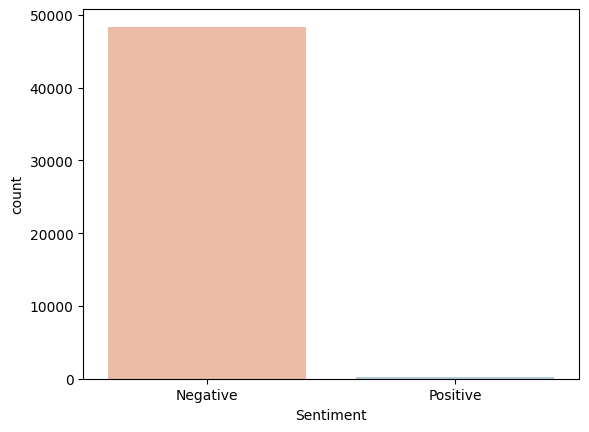

In [71]:
sns.countplot(x='Sentiment', data=text, palette='RdBu')

Model predicts that 64.3% messages are negative in the SMS corpus.

Now we want to compare the sentiment per country.

To make this easier transform the sentiment into numeric variable, positive messages are 1 and negative are -1.

In [105]:
# Define a function to convert sentiment into binary values
def convert_sentiment(sentiment):
    if sentiment == 'Positive':
        return 1
    else:
        return -1

# Create new feature based on the values returned from function
text['Sentiment_score'] = text['Sentiment'].apply(convert_sentiment)

#check
text.head()

,Unnamed: 0,id,Message,length,country,Date,Message_lowercase,message_clean,Sentiment,Sentiment_score
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat...,bugis oso near wat...,Negative,-1
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,"go until jurong point, crazy.. available only ...","go until jurong point, crazy.. available only ...",Negative,-1
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when... lets go learn pilates...,i dunno until when... lets go learn pilates...,Negative,-1
3,3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,den only weekdays got special price... haiz......,den only weekdays got special price... haiz......,Negative,-1
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la...,meet after lunch la...,Negative,-1


Create new feature column Sentiment_score and sort values based on it.

In [107]:
text['country'].dtype

dtype('O')

In [74]:
text = pd.DataFrame(text)

In [75]:
text.sort_values(by='Sentiment_score')

,Unnamed: 0,id,Message,length,country,Date,Message_lowercase,message_clean,Sentiment,Sentiment_score
32355,35606,25490,Ya good. Thanks.,16,Singapore,2011/4,ya good. thanks.,ya good. thanks.,Negative,-1
32344,35595,25479,Okay can help me buy 4 packers of flour and 1 ...,60,Singapore,2011/4,okay can help me buy 4 packers of flour and 1 ...,okay can help me buy 4 packers of flour and 1 ...,Negative,-1
32345,35596,25480,Remember to get receipt eh.,27,Singapore,2011/4,remember to get receipt eh.,remember to get receipt eh.,Negative,-1
32346,35597,25481,Hey call those participants that want to come ...,119,Singapore,2011/4,hey call those participants that want to come ...,hey call those participants that want to come ...,Negative,-1
32347,35598,25482,Hahaha yuppp,12,Singapore,2011/4,hahaha yuppp,hahaha yuppp,Negative,-1
...,...,...,...,...,...,...,...,...,...,...
10746,11314,1198,<DECIMAL> %,11,India,2010/12,<decimal> %,%,Positive,1
28964,31763,21647,我在上课,4,Singapore,2011/4,我在上课,我在上课,Positive,1
13418,14297,4181,4,1,India,2011/1,4,4,Positive,1
32655,35966,25850,Awwwwwww,8,Singapore,2011/4,awwwwwww,awwwwwww,Positive,1


Now group by each country and get the average sentiment score with mean() method for each country.

In [124]:
text.sort_values(by='Sentiment_score')

,Unnamed: 0,id,Message,length,country,Date,Message_lowercase,message_clean,Sentiment,Sentiment_score
32355,35606,25490,Ya good. Thanks.,16,Singapore,2011/4,ya good. thanks.,ya good. thanks.,Negative,-1
32344,35595,25479,Okay can help me buy 4 packers of flour and 1 ...,60,Singapore,2011/4,okay can help me buy 4 packers of flour and 1 ...,okay can help me buy 4 packers of flour and 1 ...,Negative,-1
32345,35596,25480,Remember to get receipt eh.,27,Singapore,2011/4,remember to get receipt eh.,remember to get receipt eh.,Negative,-1
32346,35597,25481,Hey call those participants that want to come ...,119,Singapore,2011/4,hey call those participants that want to come ...,hey call those participants that want to come ...,Negative,-1
32347,35598,25482,Hahaha yuppp,12,Singapore,2011/4,hahaha yuppp,hahaha yuppp,Negative,-1
...,...,...,...,...,...,...,...,...,...,...
10746,11314,1198,<DECIMAL> %,11,India,2010/12,<decimal> %,%,Positive,1
28964,31763,21647,我在上课,4,Singapore,2011/4,我在上课,我在上课,Positive,1
13418,14297,4181,4,1,India,2011/1,4,4,Positive,1
32655,35966,25850,Awwwwwww,8,Singapore,2011/4,awwwwwww,awwwwwww,Positive,1


In [110]:
#create a new dataframe grouped by countries and aggregated by the mean.
text_sent = text.groupby(['country']).mean()

#reset the index
text_sent.reset_index(inplace=True)

text_sent.head()

AttributeError: 'DataFrameGroupBy' object has no attribute 'reset_index'

Want to know which country sends the most positive messages so use sort_values() on sentiment score.

In [115]:
text_sent = text.groupby(['country']).Sentiment_score.mean()

In [116]:
text_sent.head()

,Sentiment_score
country,
Australia,-1.000000
Bangladesh,-0.984127
Barbados,-1.000000
Canada,-1.000000
China,-1.000000


In [122]:
text_sent

,Sentiment_score
country,
Australia,-1.000000
Bangladesh,-0.984127
Barbados,-1.000000
Canada,-1.000000
China,-1.000000
France,-1.000000
Ghana,-1.000000
Hungary,-1.000000
India,-0.985039


In [123]:
text_sent.max()

-0.9700996677740864

In [121]:
text_sent = text.groupby(['country']).Sentiment_score.mean().sort_values(by='Sentiment_score')

TypeError: Series.sort_values() got an unexpected keyword argument 'by'

In [120]:
# Sort DataFrame by Sentiment_score
text_sent.sort_values(by='Sentiment_score')

TypeError: Series.sort_values() got an unexpected keyword argument 'by'

I didn't get the same result as the original script, for me all countries sent a negative message on average whereas in the original script some countries like Spain or Australia had positive average sentiment scores.

**I'm guessing is that this was caused by the tokenisation method which resulted in  the classifier being trained slightly differently and generating different sentiment scores at the end.**

For me word_tokenize() didn't work and i had to use tokenized() method.